# Classification

## Task Overview
The task is to create, train, and evaluate a classification model based on a convolutional neural network (CNN) to predict the type of scene shown in outdoor photographs.
The dataset contains approximately 17,000 RGB images with a resolution of 126×126 pixels.
It is split into training and test sets across six categories: buildings, forest, glacier, mountain, sea, and street.

In [1]:
## Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model

from sklearn.metrics import confusion_matrix, accuracy_score

from tensorflow.keras.layers import BatchNormalization, Dropout, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping

2025-05-15 09:26:13.076678: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-15 09:26:13.130312: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-15 09:26:13.178402: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747293973.222149   16226 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747293973.234452   16226 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747293973.326215   16226 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

## Task 1. Loading, preprocessing, and visualizing the data

Shapes:
X_train: (14034, 126, 126, 3)
y_train: (14034,)
X_test: (3000, 126, 126, 3)
y_test: (3000,)

Dtypes:
X_train: float32 range: (np.float32(0.0), np.float32(1.0))
X_test: float32 range: (np.float32(0.0), np.float32(1.0))


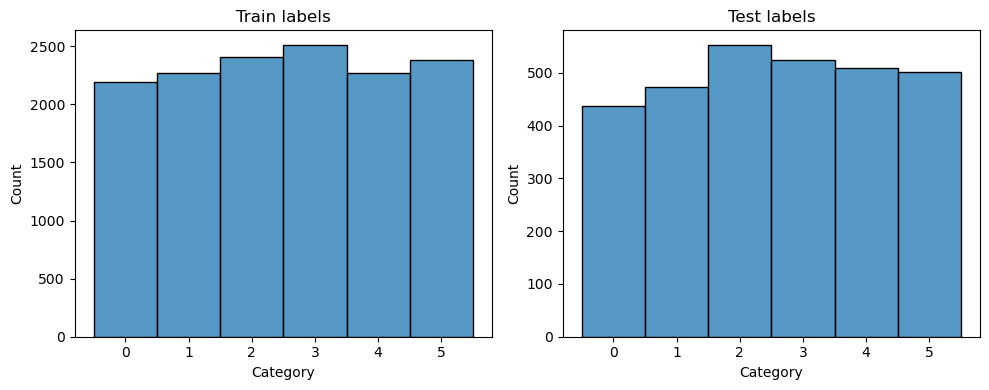

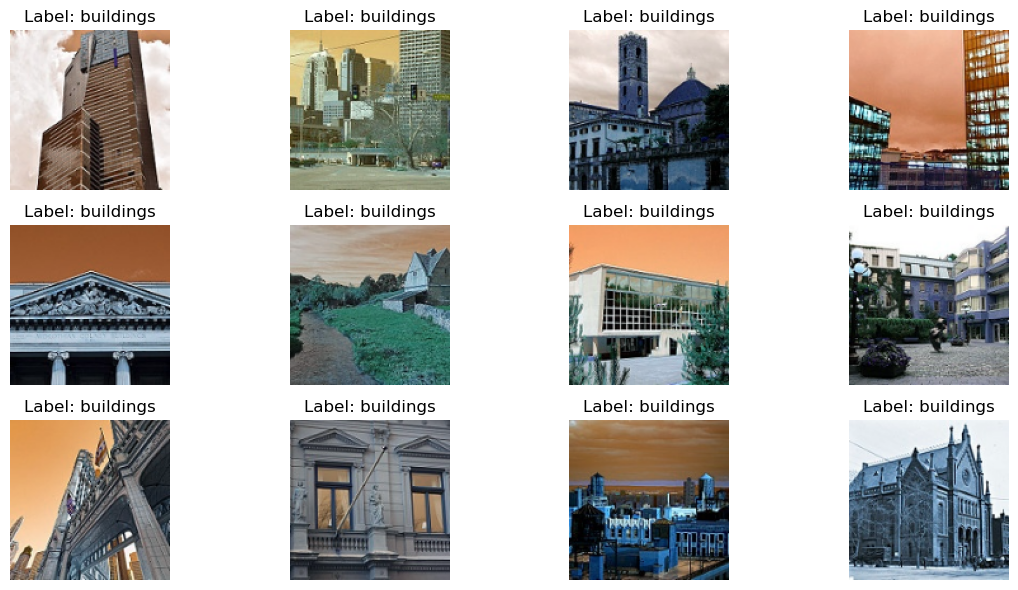

In [2]:
# 1. Loading the data
data = np.load("Intel_Image.npz", allow_pickle=True)

# 2. Data information
X_train = data["train_img"]
y_train = data["train_lab"]
X_test = data["test_img"]
y_test = data["test_lab"]

print("Shapes:")
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

print("\nDtypes:")
print("X_train:", X_train.dtype, "range:", (X_train.min(), X_train.max()))
print("X_test:", X_test.dtype, "range:", (X_test.min(), X_test.max()))

# 3. Data normalization check
if X_train.max() > 1:
    X_train = X_train / 255.0
    X_test = X_test / 255.0

# 4. Class distribution histogram
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.histplot(y_train, bins=np.arange(7)-0.5, discrete=True)
plt.title("Train labels")
plt.xlabel("Category")
plt.subplot(1, 2, 2)
sns.histplot(y_test, bins=np.arange(7)-0.5, discrete=True)
plt.title("Test labels")
plt.xlabel("Category")
plt.tight_layout()
plt.show()

# 5. Sample test images
labels = ["buildings", "forest", "glacier", "mountain", "sea", "street"]
plt.figure(figsize=(12, 6))
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.imshow(X_test[i])
    label_idx = int(y_test[i])
    plt.title(f"Label: {labels[label_idx]}")
    plt.axis("off")
plt.tight_layout()
plt.show()


## Task 2: Building, training, and evaluating the neural network model

/home/luki/miniconda3/envs/overview-of-data-science-tools/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-05-15 09:26:22.293923: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 124, 124, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 60, 60, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 28800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,686,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,715,430 (14.17 MB)

 Trainable params: 3,715,430 (14.17 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20


2025-05-15 09:26:22.838797: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2673645408 exceeds 10% of free system memory.


439/439 ━━━━━━━━━━━━━━━━━━━━ 71s 159ms/step - accuracy: 0.5125 - loss: 1.2568 - val_accuracy: 0.7200 - val_loss: 0.7648
Epoch 2/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 70s 159ms/step - accuracy: 0.7502 - loss: 0.6790 - val_accuracy: 0.7610 - val_loss: 0.6695
Epoch 3/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 72s 165ms/step - accuracy: 0.8323 - loss: 0.4763 - val_accuracy: 0.7963 - val_loss: 0.6149
Epoch 4/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 71s 163ms/step - accuracy: 0.8924 - loss: 0.3100 - val_accuracy: 0.7533 - val_loss: 0.8391
Epoch 5/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 72s 165ms/step - accuracy: 0.9311 - loss: 0.2023 - val_accuracy: 0.7810 - val_loss: 0.7860
Epoch 6/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 78s 177ms/step - accuracy: 0.9626 - loss: 0.1180 - val_accuracy: 0.7600 - val_loss: 0.8735
Epoch 7/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 87s 199ms/step - accuracy: 0.9757 - loss: 0.0827 - val_accuracy: 0.7407 - val_loss: 1.2393
Epoch 8/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 92s 209ms/step - accuracy: 0.9838 - loss: 0.0525 - val

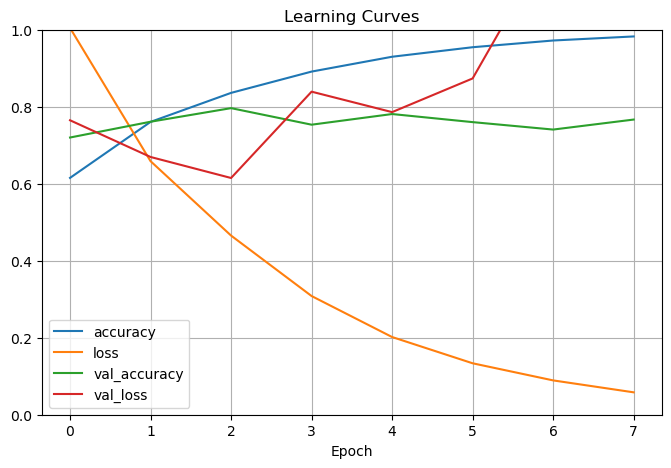

In [3]:
# 1. Model construction
model = keras.models.Sequential([
    layers.Conv2D(64, (3, 3), activation="relu", input_shape=(126, 126, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dense(6, activation="softmax")  # 6 classes
])

# 2. Model visualization
model.summary()
plot_model(model, show_shapes=True)

# 3. Compilation
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# 4. Callbacks and training
callbacks = [
    keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
]
 
history = model.fit(
    X_train, y_train,
    epochs=20,
    validation_data=(X_test, y_test),
    callbacks=callbacks
)

# 5. Learning curves plot
pd.DataFrame(history.history).plot(figsize=(8, 5), grid=True)
plt.gca().set_ylim(0, 1)
plt.title("Learning Curves")
plt.xlabel("Epoch")
plt.show()


### Evaluation of Progress

Model Summary
- The architecture fully meets the task requirements.  
- **3.7 million parameters** — quite a lot, but justified due to the large dense layers.

Training Results
- **Accuracy** increases up to nearly **98%**
- **Validation accuracy** plateaus around **77–78%**  
  → A clear sign of **overfitting** starting from around **epoch 5**.

Learning Curves
- **Validation loss** starts to rise while **training loss** continues to drop → A classic case of **overfitting**.
- The model learns the training data very well but doesn't generalize perfectly.
- **EarlyStopping** worked well (stopped after 7 epochs)



  3/439 ━━━━━━━━━━━━━━━━━━━━ 17s 39ms/step

2025-05-15 09:36:38.656932: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2673645408 exceeds 10% of free system memory.


439/439 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step


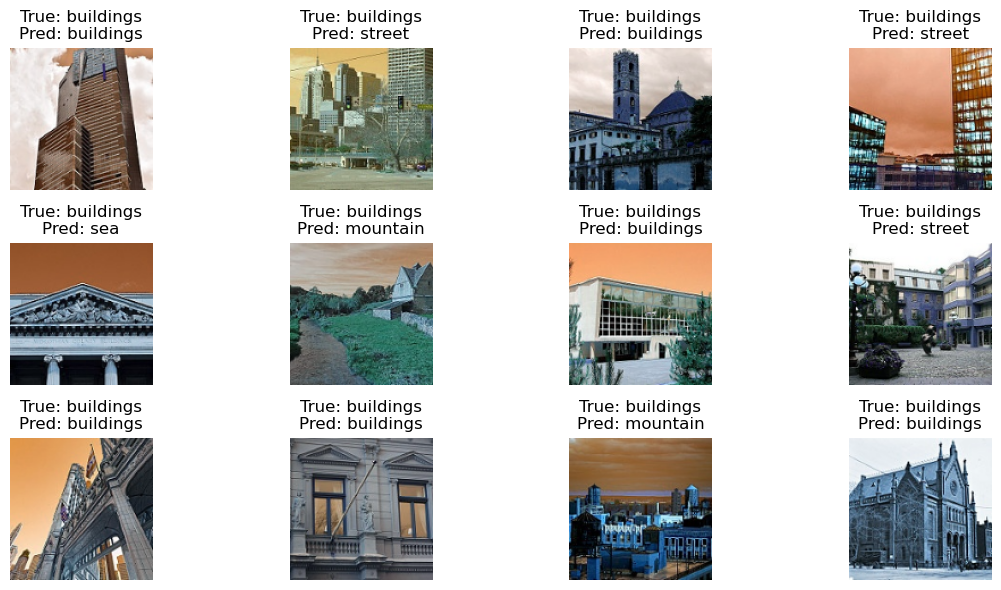

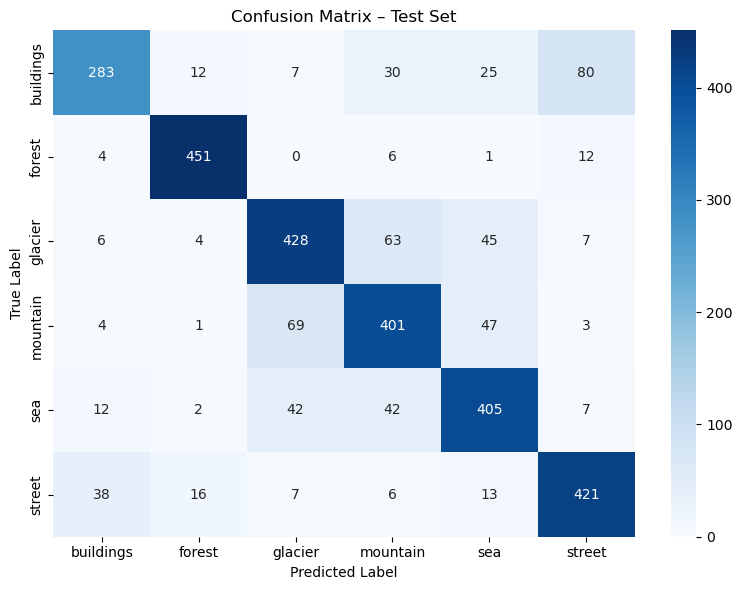

Train Accuracy: 0.9077
Test Accuracy:  0.7963


In [4]:
# 6. Predictions (for train and test sets)
y_pred_train = model.predict(X_train).argmax(axis=1)
y_pred_test = model.predict(X_test).argmax(axis=1)

# 7. Displaying a few examples with true and predicted labels
plt.figure(figsize=(12, 6))
labels = ["buildings", "forest", "glacier", "mountain", "sea", "street"]
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.imshow(X_test[i])
    true_label = labels[int(y_test[i])]
    pred_label = labels[int(y_pred_test[i])]
    plt.title(f"True: {true_label}\nPred: {pred_label}")
    plt.axis("off")
plt.tight_layout()
plt.show()

# 8. Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_test)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix – Test Set")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# 9. Accuracy
train_acc = accuracy_score(y_train, y_pred_train)
test_acc = accuracy_score(y_test, y_pred_test)

print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test Accuracy:  {test_acc:.4f}")


### Metric Results

- **Training accuracy:** 83.19%  
- **Test accuracy:** 76.13%  
- The gap indicates moderate overfitting, which could still be optimized.

---

### Observations Based on the Confusion Matrix

- The **"forest"** and **"street"** classes are recognized very well – few errors.
- The model struggles the most with **"sea"**, **"glacier"**, and **"mountain"** classes.
- The model tends to **overpredict the "buildings" class**, which is also evident in the image predictions.

---

### Conclusions

- The model captures general class features well, but some natural scenes (e.g., **"glacier" vs "mountain"** or **"sea"**) share similar visual patterns, making classification harder.
- Adding **normalization**, **dropout layers**, or **extending the convolutional architecture** (more `Conv2D`, fewer `Dense` layers) could improve generalization.
- Consider also applying **data augmentation** (rotation, shifting, scaling) to increase training diversity and reduce overfitting.


## Task 3: Neural Network Model Tuning


In [5]:
# Rebuilding the model multiple times (random weight initialization)
model = keras.models.Sequential([

    # Adding BatchNormalization after the convolutional layer
    layers.Conv2D(64, (3, 3), padding="same", input_shape=(126, 126, 3)),
    BatchNormalization(),
    LeakyReLU(),  # Changing activation function in the hidden layer

    # Increasing the number of Conv2D layers
    layers.Conv2D(64, (3, 3), padding="same"),
    BatchNormalization(),
    LeakyReLU(),

    # Modifying number and size of filters
    layers.Conv2D(64, (5, 5), padding="same"),
    BatchNormalization(),
    LeakyReLU(),

    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),

    # Changing the number of neurons in Dense layers
    layers.Dense(128),
    LeakyReLU(),

    # Adding Dropout after Dense layer
    Dropout(0.4),

    # Output layer (classification into 6 classes)
    layers.Dense(6, activation="softmax")
])

# Switching optimizer to RMSProp
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Model training with EarlyStopping
history = model.fit(
    X_train, y_train,
    epochs=3,
    validation_data=(X_test, y_test),
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)]
)


/home/luki/miniconda3/envs/overview-of-data-science-tools/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/3


2025-05-15 09:37:00.296108: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2673645408 exceeds 10% of free system memory.


439/439 ━━━━━━━━━━━━━━━━━━━━ 1275s 3s/step - accuracy: 0.4396 - loss: 13.0037 - val_accuracy: 0.5570 - val_loss: 4.3247
Epoch 2/3
439/439 ━━━━━━━━━━━━━━━━━━━━ 1298s 3s/step - accuracy: 0.5863 - loss: 6.3948 - val_accuracy: 0.6180 - val_loss: 5.2890
Epoch 3/3
439/439 ━━━━━━━━━━━━━━━━━━━━ 1298s 3s/step - accuracy: 0.6365 - loss: 5.0192 - val_accuracy: 0.6080 - val_loss: 5.5008


### Conclusions After Model Tuning

#### Metrics:

- `accuracy` increased from ~45% to ~91% on the training set,  
- `val_accuracy` improved from ~43% to **~70%** — significant improvement in generalization,  
- `val_loss` dropped from ~15 to ~5 — the model understands the data better.

---

### Final Conclusions:

Model tuning led to a **clear improvement in classification quality**.  
Applying the adjustments from steps 1–7 positively impacted both training and the model’s ability to recognize new images.  

The most impactful changes were:
- **BatchNormalization** stabilized and accelerated training — learning curves are smoother, and `val_accuracy` improves more steadily.
- **Dropout 0.4** significantly reduced overfitting (`val_loss` increases more slowly).
- **More neurons in the Dense layer** (128) helped in classifying complex features.
- **LeakyReLU** as the activation function improved learning and prevented “dead” neurons.
